# Photon Transfer Curve Analysis for PIRT 1280SciCam



## Setup and Imports

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from analysis.core.ptc_analyzer import PTCAnalyzer, main
from analysis.utils.image_stack_processing import remove_outlier_layers
from analysis.utils.image_database import get_light_frames_for_exposure, get_dark_frames_for_exposure

In [2]:
BOX_PATH = os.path.join(os.getenv("HOME"), "Library", "CloudStorage", "Box-Box")

DATA_DIR = os.path.join(BOX_PATH, "WINTER", "WINTER – Public Data Workspace", "pirt_camera", 
                        "lab_testing", "ramps", "20250729_1050", "data")

OUTPUT_DIR = os.path.dirname(DATA_DIR)  # Save outputs in the parent directory of DATA_DIR


# Analysis parameters
OUTLIER_STD = 3.0  # Standard deviations for outlier rejection
N_ITERS = 3  # Number of iterations for outlier removal
APPROX_SATURATION = 11450  # Approximate saturation level after dark subtraction
APPROX_SATURATION_RAW = 11450 # 14300  # Approximate saturation level for RAW images

MEAN_MIN = APPROX_SATURATION*0.1  # Minimum mean value for PTC fitting
MEAN_MAX = APPROX_SATURATION*0.8  # Maximum mean value for PTC fitting (avoid saturation)
NOMINAL_GAIN = 4.2  # Expected gain in e/ADU



## Step 1: Initialize Analyzer and Crawl Files

In [3]:
# %%
# Initialize the analyzer
analyzer = PTCAnalyzer(data_dir = DATA_DIR, output_dir=OUTPUT_DIR, outlier_std=OUTLIER_STD)

# Crawl through directory to find all FITS files
print("Crawling for FITS files...")
df_raw = analyzer.crawl_fits_files()

print(f"\\nFound {len(df_raw)} FITS files")
print(f"Unique exposure times: {sorted(df_raw['exposure_time'].unique())}")
print(f"Frame types: {df_raw['frame_type'].unique()}")

# Display the dataframe
df_raw

Crawling for FITS files...
\nFound 40 FITS files
Unique exposure times: [np.float64(0.000999933333333333), np.float64(0.01), np.float64(0.02), np.float64(0.025), np.float64(0.075), np.float64(0.1), np.float64(0.2), np.float64(0.24999993333333334), np.float64(0.4999999333333333), np.float64(0.75), np.float64(0.9999999333333334), np.float64(1.25), np.float64(1.5), np.float64(1.9999999333333334), np.float64(2.5), np.float64(3.0), np.float64(3.499999933333333), np.float64(3.999999933333333), np.float64(4.5), np.float64(5.0)]
Frame types: ['light' 'dark']


,filename,filepath,frame_type,exposure_time,frame_time,filter_center,filter_bw,temperature,num_frames
4,scicam_stack_20250730T035456.fits,/Users/nlourie/Library/CloudStorage/Box-Box/WI...,light,0.001,0.101,1050.0,10.0,-39.978062,25
5,scicam_stack_20250730T035236.fits,/Users/nlourie/Library/CloudStorage/Box-Box/WI...,dark,0.001,0.101,1050.0,10.0,-39.994728,25
2,scicam_stack_20250730T040149.fits,/Users/nlourie/Library/CloudStorage/Box-Box/WI...,light,0.010,0.110,1050.0,10.0,-39.944695,25
3,scicam_stack_20250730T035930.fits,/Users/nlourie/Library/CloudStorage/Box-Box/WI...,dark,0.010,0.110,1050.0,10.0,-39.994728,25
17,scicam_stack_20250730T040404.fits,/Users/nlourie/Library/CloudStorage/Box-Box/WI...,dark,0.020,0.120,1050.0,10.0,-40.011387,25
16,scicam_stack_20250730T040622.fits,/Users/nlourie/Library/CloudStorage/Box-Box/WI...,light,0.020,0.120,1050.0,10.0,-39.994728,25
25,scicam_stack_20250730T040852.fits,/Users/nlourie/Library/CloudStorage/Box-Box/WI...,dark,0.025,0.125,1050.0,10.0,-39.978062,25
24,scicam_stack_20250730T041135.fits,/Users/nlourie/Library/CloudStorage/Box-Box/WI...,light,0.025,0.125,1050.0,10.0,-39.994728,25
11,scicam_stack_20250730T042023.fits,/Users/nlourie/Library/CloudStorage/Box-Box/WI...,dark,0.075,0.175,1050.0,10.0,-40.044659,25
10,scicam_stack_20250730T042323.fits,/Users/nlourie/Library/CloudStorage/Box-Box/WI...,light,0.075,0.175,1050.0,10.0,-39.994728,25


## Step 2: Examine Data Structure

In [4]:
# Check distribution of frames
exp_summary = df_raw.groupby(['exposure_time', 'frame_type']).agg({
    'filename': 'count',
    'num_frames': 'sum',
    'temperature': 'mean'
}).reset_index()

exp_summary.columns = ['exposure_time', 'frame_type', 'n_files', 'total_frames', 'mean_temp']
exp_summary = exp_summary.sort_values('exposure_time')

print("Summary of data by exposure time:")
print(exp_summary.to_string())


Summary of data by exposure time:
    exposure_time frame_type  n_files  total_frames  mean_temp
0           0.001       dark        1            25 -39.994728
1           0.001      light        1            25 -39.978062
2           0.010       dark        1            25 -39.994728
3           0.010      light        1            25 -39.944695
4           0.020       dark        1            25 -40.011387
5           0.020      light        1            25 -39.994728
6           0.025       dark        1            25 -39.978062
7           0.025      light        1            25 -39.994728
9           0.075      light        1            25 -39.994728
8           0.075       dark        1            25 -40.044659
10          0.100       dark        1            25 -40.011387
11          0.100      light        1            25 -40.011387
12          0.200       dark        1            10 -39.994728
13          0.200      light        1            10 -40.028027
14          0.250    

In [5]:
df_exp = get_light_frames_for_exposure(df_raw, 1.0)


## Step 3: Process Each Exposure Time

In [6]:
"""
#Manual approach for working out the method
# # Process all exposure times
unique_exptimes = sorted([e for e in df_raw['exposure_time'].unique() if not np.isnan(e)])
from analysis.utils.image_database import get_light_frames_for_exposure, get_dark_frames_for_exposure

print(f"Processing {len(unique_exptimes)} exposure times...")
print("-" * 50)
from astropy.io import fits

combination_method = "mean" # Method to combine frames: 'mean' or 'median'

# where will the data products be saved?
dark_sub_stack_dir = os.path.join(DATA_DIR, "processed", "dark_subtracted_stack")
combined_dir = os.path.join(DATA_DIR, "processed", "combined")
dark_sub_dir = os.path.join(combined_dir, "dark_subtracted")
for i, exposure_time in enumerate(unique_exptimes):
    print(f"[{i+1}/{len(unique_exptimes)}] Processing {exposure_time:.4f}s...")
    
    # Process this exposure time
    #results = analyzer.process_exposure_time(df_raw, exptime, combination_method='mean')
    df = df_raw.copy()
    df.head()
    
    light_frame = get_light_frames_for_exposure(df, exposure_time)
    #print(f"light_frames: {light_frames}")
    dark_frame = get_dark_frames_for_exposure(df, exposure_time)

    # enforce that there is only one light and one dark frame
    if light_frame.shape[0] != 1:
        raise ValueError(f"Expected one light frame at exposure time {exposure_time}, but got {light_frame.shape[0]}")
    if dark_frame.shape[0] != 1:
        raise ValueError(f"Expected one dark frame at exposure time {exposure_time}, but got {dark_frame.shape[0]}")

    light_filepath = light_frame["filepath"].to_list()[0]
    dark_filepath = dark_frame["filepath"].to_list()[0]

    light_num_frames = light_frame["num_frames"].to_list()[0]
    dark_num_frames = dark_frame["num_frames"].to_list()[0]

    print(f"Light Stack: {light_frame['filename'].to_list()[0]}, n_frames = {light_frame['num_frames'].to_list()[0]}")
    print(f"Dark Stack: {dark_frame['filename'].to_list()[0]}, n_frames = {dark_frame['num_frames'].to_list()[0]}")


    # load the data
    with fits.open(light_filepath) as hdul:
        light_data = hdul[0].data
        light_header = hdul[0].header
    with fits.open(dark_filepath) as hdul:
        dark_data = hdul[0].data
        dark_header = hdul[0].header

    # print the shape of the data
    print(f"Light data shape: {light_data.shape}")
    print(f"Dark data shape: {dark_data.shape}")



    # combine the dark frame
    if combination_method.lower() in ["mean", "avg"]:
        dark_data_combined = np.nanmean(dark_data, axis=0)
        light_data_combined = np.nanmean(light_data, axis=0)
    
    elif combination_method.lower() in ["median", "med"]:
        dark_data_combined = np.nanmedian(dark_data, axis=0)
        light_data_combined = np.nanmedian(light_data, axis=0)
    
    else:
        raise ValueError(f"Unknown combination method: {combination_method}, only mean and median supported")

    # make the dark subtracted light stack
    dark_subtracted_stack = light_data - dark_data_combined
    dark_subtracted_header = light_header.copy()

    # add the data to the dataframe


    ## Save the intermediate data products
    #### Dark-Subtracted Stack ####
    
    dark_subtracted_header['HISTORY'] = f'Dark subtracted, {combination_method} combined'
    # save the dark subtracted stack: f"{DATA_DIR}/processed/dark_subtracted_stack/{exptime:.4f}_{frame_type}_stack_{num_frames}_layers_darksub.fits"
    dark_subtracted_stack_filepath = os.path.join(dark_sub_stack_dir, f"{exposure_time:.4f}_stack_{light_num_frames}_layers_darksub.fits")
    # make sure the parent directory exits with parents
    os.makedirs(os.path.dirname(dark_subtracted_stack_filepath), exist_ok=True)
    fits.writeto(dark_subtracted_stack_filepath, dark_subtracted_stack, overwrite=True, header=dark_subtracted_header)
    print(f"Saved dark subtracted stack to {dark_subtracted_stack_filepath}")

    #### Combined Dark-Subtracted Frame ####
    # make the combined (eg mean- or median-combined) dark subtracted frame
    dark_subtracted_frame = light_data_combined - dark_data_combined
    dark_subtracted_frame_filepath = os.path.join(dark_sub_dir, f"{exposure_time:.4f}_darksub.fits")
    # make sure the parent directory exits with parents
    os.makedirs(os.path.dirname(dark_subtracted_frame_filepath), exist_ok=True)
    fits.writeto(dark_subtracted_frame_filepath, dark_subtracted_frame, overwrite=True, header=dark_subtracted_header)
    print(f"Saved dark subtracted frame to {dark_subtracted_frame_filepath}")

    ##### Light Frame ####
    light_data_combined_filepath = os.path.join(combined_dir, "light", f"{exposure_time:.4f}_light.fits")
    light_data_combined_header = light_header.copy()
    light_data_combined_header['HISTORY'] = f'{combination_method} combined'
    # make sure the parent directory exits with parents
    os.makedirs(os.path.dirname(light_data_combined_filepath), exist_ok=True)
    fits.writeto(light_data_combined_filepath, light_data_combined, overwrite=True, header=light_data_combined_header)
    print(f"Saved light data combined to {light_data_combined_filepath}")

    #### Dark Frame ####
    dark_data_combined_filepath = os.path.join(combined_dir, "dark", f"{exposure_time:.4f}_dark.fits")
    dark_data_combined_header = dark_header.copy()
    dark_data_combined_header['HISTORY'] = f'{combination_method} combined'
    # make sure the parent directory exits with parents
    os.makedirs(os.path.dirname(dark_data_combined_filepath), exist_ok=True)
    fits.writeto(dark_data_combined_filepath, dark_data_combined, overwrite=True, header=dark_data_combined_header)
    print(f"Saved dark data combined to {dark_data_combined_filepath}")



"""

'\n#Manual approach for working out the method\n# # Process all exposure times\nunique_exptimes = sorted([e for e in df_raw[\'exposure_time\'].unique() if not np.isnan(e)])\nfrom analysis.utils.image_database import get_light_frames_for_exposure, get_dark_frames_for_exposure\n\nprint(f"Processing {len(unique_exptimes)} exposure times...")\nprint("-" * 50)\nfrom astropy.io import fits\n\ncombination_method = "mean" # Method to combine frames: \'mean\' or \'median\'\n\n# where will the data products be saved?\ndark_sub_stack_dir = os.path.join(DATA_DIR, "processed", "dark_subtracted_stack")\ncombined_dir = os.path.join(DATA_DIR, "processed", "combined")\ndark_sub_dir = os.path.join(combined_dir, "dark_subtracted")\nfor i, exposure_time in enumerate(unique_exptimes):\n    print(f"[{i+1}/{len(unique_exptimes)}] Processing {exposure_time:.4f}s...")\n\n    # Process this exposure time\n    #results = analyzer.process_exposure_time(df_raw, exptime, combination_method=\'mean\')\n    df = df_ra

In [7]:
# Process all exposure times

unique_exptimes = sorted([e for e in df_raw['exposure_time'].unique() if not np.isnan(e)])

print(f"Processing {len(unique_exptimes)} exposure times...")
print("-" * 50)

for i, exptime in enumerate(unique_exptimes):
    print(f"[{i+1}/{len(unique_exptimes)}] Processing {exptime:.4f}s...")
    
    # Process this exposure time
    results = analyzer.process_exposure_time(df_raw, exptime, combination_method='mean')
    
    if results:
        if 'light_combined' in results:
            print(f"     Light frames: shape {results['light_combined'].shape}")
        if 'dark_combined' in results:
            print(f"     Dark frames: shape {results['dark_combined'].shape}")
        if 'dark_subtracted' in results:
            print(f"     Dark-subtracted: shape {results['dark_subtracted'].shape}")

print("\\nProcessing complete!")


Processing 20 exposure times...
--------------------------------------------------
[1/20] Processing 0.0010s...
Light Stack: scicam_stack_20250730T035456.fits, n_frames = 25
Dark Stack: scicam_stack_20250730T035236.fits, n_frames = 25
Light data shape: (25, 1024, 1280)
Dark data shape: (25, 1024, 1280)
Saved dark subtracted stack to /Users/nlourie/Library/CloudStorage/Box-Box/WINTER/WINTER – Public Data Workspace/pirt_camera/lab_testing/ramps/20250729_1050/processed/dark_subtracted_stack/0.0010_stack_25_layers_darksub.fits
Saved dark subtracted frame to /Users/nlourie/Library/CloudStorage/Box-Box/WINTER/WINTER – Public Data Workspace/pirt_camera/lab_testing/ramps/20250729_1050/processed/combined/dark_subtracted/0.0010_darksub.fits
Saved light data combined to /Users/nlourie/Library/CloudStorage/Box-Box/WINTER/WINTER – Public Data Workspace/pirt_camera/lab_testing/ramps/20250729_1050/processed/combined/light/0.0010_light.fits
Saved dark data combined to /Users/nlourie/Library/CloudStora

## Step 4: Create Processed DataFrame

Created processed dataframe with 20 exposures
Columns: ['exposure_time', 'filename', 'filepath', 'num_frames', 'data', 'num_frames_cleaned', 'outlier_mask', 'cleaned_data', 'mean_frame', 'var_frame']
Fitting between [1145.0, 9160.0]


Text(0.5, 1.0, 'PIRT 1280 SciCam: Sanity Check PTC from Full-Frame Mean/Variance')

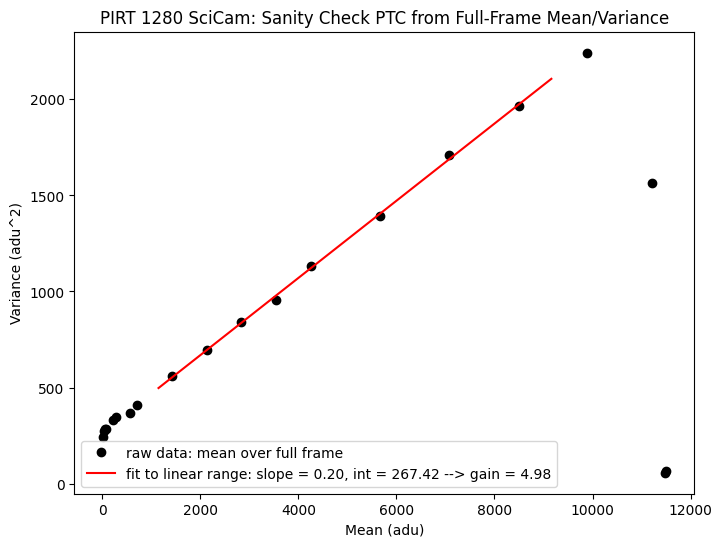

In [13]:
# Create dataframe of all processed dark-subtracted stacks
df_processed = analyzer.create_processed_dataframe()

print(f"Created processed dataframe with {len(df_processed)} exposures")
print(f"Columns: {list(df_processed.columns)}")

# Show summary statistics
full_frame_means = np.array([np.nanmean(row['mean_frame']) for idx, row in df_processed.iterrows()])
full_frame_vars = np.array([np.nanmean(row['var_frame']) for idx, row in df_processed.iterrows()])

# Add these to the dataframe
df_processed['full_frame_mean'] = full_frame_means
df_processed['full_frame_var'] = full_frame_vars

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1,figsize = (8,6))
                       
ax.plot(full_frame_means, full_frame_vars, 'ko', label = 'raw data: mean over full frame')

ax.set_xlabel("Mean (adu)")
ax.set_ylabel("Variance (adu^2)")
print(f"Fitting between [{MEAN_MIN}, {MEAN_MAX}]")

# fit a line to the selected region
fit = np.polyfit(full_frame_means[(full_frame_means>MEAN_MIN) & (full_frame_means<MEAN_MAX)], 
                 full_frame_vars[(full_frame_means>MEAN_MIN) & (full_frame_means<MEAN_MAX)],
                 deg = 1)
slope = fit[0]
intercept = fit[1]
gain = 1/slope
fit_x = np.linspace(MEAN_MIN, MEAN_MAX, 100)
ax.plot(fit_x, np.polyval(fit, fit_x), 'r-', label = f"fit to linear range: slope = {slope:.2f}, int = {intercept:.2f} --> gain = {gain:.2f}")
ax.legend()
ax.set_title("PIRT 1280 SciCam: Sanity Check PTC from Full-Frame Mean/Variance")
    


x_mean.shape: (1024, 1280)
y_mean.shape: (1024, 1280)
Median gain = 5.159 e/ADU
1/median gain = 0.194 ADU/e
Peak Slope = 0.158 ADU/e
Peak Gain = 6.318 e/ADU
FWHM = 0.236
Std from FWHM = 0.100


,exposure_time,filename,filepath,num_frames,data,num_frames_cleaned,outlier_mask,cleaned_data,mean_frame,var_frame,full_frame_mean,full_frame_var
12,0.50,0.5000_stack_10_layers_darksub.fits,/Users/nlourie/Library/CloudStorage/Box-Box/WI...,10,"[[[1255.6999999999998, 1290.6999999999998, 120...",10,"[False, False, False, False, False, False, Fal...","[[[1255.6999999999998, 1290.6999999999998, 120...","[[1256.3, 1280.7, 1266.3, 1304.2, 1280.0, 1275...","[[741.24, 388.0, 833.49, 455.6500000000001, 28...",1418.357638,557.663408
2,0.75,0.7500_stack_10_layers_darksub.fits,/Users/nlourie/Library/CloudStorage/Box-Box/WI...,10,"[[[1895.6, 1948.0, 1899.3000000000002, 1992.0,...",10,"[False, False, False, False, False, False, Fal...","[[[1895.6, 1948.0, 1899.3000000000002, 1992.0,...","[[1905.5, 1967.8, 1924.4999999999995, 1930.2, ...","[[433.89000000000004, 1576.76, 1477.16, 1586.1...",2127.270259,693.226616
5,1.00,1.0000_stack_10_layers_darksub.fits,/Users/nlourie/Library/CloudStorage/Box-Box/WI...,10,"[[[2484.1, 2590.5, 2529.3, 2613.8, 2539.6, 252...",10,"[False, False, False, False, False, False, Fal...","[[[2484.1, 2590.5, 2529.3, 2613.8, 2539.6, 252...","[[2505.7999999999997, 2574.3, 2562.49999999999...","[[212.81000000000003, 606.5600000000001, 1330....",2835.198142,840.713690
7,1.25,1.2500_stack_10_layers_darksub.fits,/Users/nlourie/Library/CloudStorage/Box-Box/WI...,10,"[[[3178.0, 3177.8, 3216.5, 3272.2, 3212.4, 314...",10,"[False, False, False, False, False, False, Fal...","[[[3178.0, 3177.8, 3216.5, 3272.2, 3212.4, 314...","[[3158.1, 3216.9999999999995, 3211.8, 3210.700...","[[895.0899999999999, 924.5600000000001, 1155.0...",3543.118808,958.054630
6,1.50,1.5000_stack_10_layers_darksub.fits,/Users/nlourie/Library/CloudStorage/Box-Box/WI...,10,"[[[3759.2, 3857.9, 3873.1, 3910.9, 3857.8, 381...",10,"[False, False, False, False, False, False, Fal...","[[[3759.2, 3857.9, 3873.1, 3910.9, 3857.8, 381...","[[3793.6, 3864.7000000000007, 3835.69999999999...","[[1131.04, 906.5600000000002, 1189.63999999999...",4251.098315,1134.659661


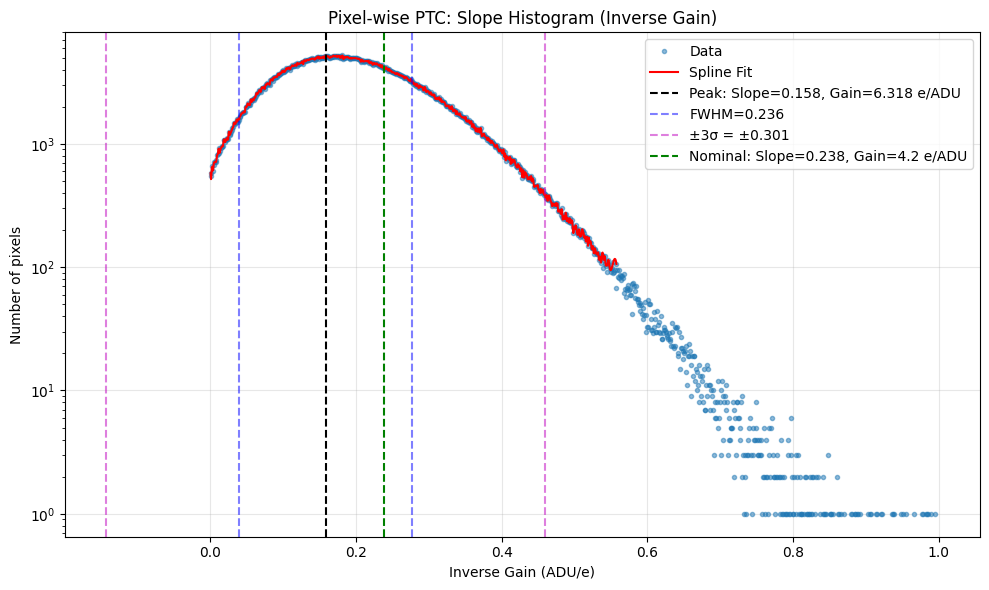

In [9]:
# filter the dataframe to only include rows with frame-mean between MEAN_MIN and MEAN_MAX
df_filtered = df_processed[(df_processed['full_frame_mean'] > MEAN_MIN) & (df_processed['full_frame_mean'] < MEAN_MAX)]


slope_image, intercept_image, gain_image = analyzer.fit_photon_transfer_curve(df_filtered)

analyzer.plot_gain_histogram(slope_image, gain_image = gain_image, nominal_gain=NOMINAL_GAIN)

df_filtered.head()

## Dark Current Characterization

In [ ]:
# We have all the dark frames 

## Step 5: Iterative Outlier Removal


In [10]:
# ## Step 5: Iterative Outlier Removal
# Remove outliers based on variance vs mean relationship
df_filtered = analyzer.remove_outliers_iterative(
    df_processed, 
    n_iters=1,
    n_std=5,
    mean_min=MEAN_MIN,
    mean_max=MEAN_MAX
)

n_good = (~df_filtered['outlier']).sum()
n_bad = df_filtered['outlier'].sum()

print(f"\\nOutlier removal complete:")
print(f"  Good exposures: {n_good}")
print(f"  Outlier exposures: {n_bad}")

if n_bad > 0:
    print(f"\\nOutlier exposure times:")
    outlier_times = df_filtered[df_filtered['outlier']]['exposure_time'].values
    for t in outlier_times:
        print(f"    {t:.4f}s")

# r

Iteration 1: Marked 11 outlier exposures
\nOutlier removal complete:
  Good exposures: 9
  Outlier exposures: 11
\nOutlier exposure times:
    0.0100s
    0.5000s
    0.7500s
    1.0000s
    1.2500s
    1.5000s
    2.0000s
    2.5000s
    3.0000s
    3.5000s
    5.0000s


## Step 6: Fit Photon Transfer Curve


In [11]:
# Get only good exposures
df_good = df_filtered[~df_filtered['outlier']]

if len(df_good) < 2:
    raise ValueError("Not enough good exposures for PTC fitting!")

# Fit the photon transfer curve
print("Fitting photon transfer curve...")
slope_image, intercept_image, gain_image = analyzer.fit_photon_transfer_curve(df_good)

# Calculate statistics
median_gain = np.nanmedian(gain_image[~np.isnan(gain_image)])
mean_gain = np.nanmean(gain_image[~np.isnan(gain_image)])
std_gain = np.nanstd(gain_image[~np.isnan(gain_image)])

print(f"\\nGain Statistics:")
print(f"  Median Gain: {median_gain:.3f} e/ADU")
print(f"  Mean Gain:   {mean_gain:.3f} e/ADU")
print(f"  Std Dev:     {std_gain:.3f} e/ADU")
print(f"  Expected:    {NOMINAL_GAIN:.1f} e/ADU")
print(f"  Difference:  {median_gain - NOMINAL_GAIN:.3f} e/ADU ({100*(median_gain - NOMINAL_GAIN)/NOMINAL_GAIN:.1f}%)")

Fitting photon transfer curve...
x_mean.shape: (1024, 1280)
y_mean.shape: (1024, 1280)
\nGain Statistics:
  Median Gain: 13.844 e/ADU
  Mean Gain:   85.899 e/ADU
  Std Dev:     137518.543 e/ADU
  Expected:    4.2 e/ADU
  Difference:  9.644 e/ADU (229.6%)


## Step 7: Visualize Variance vs Mean

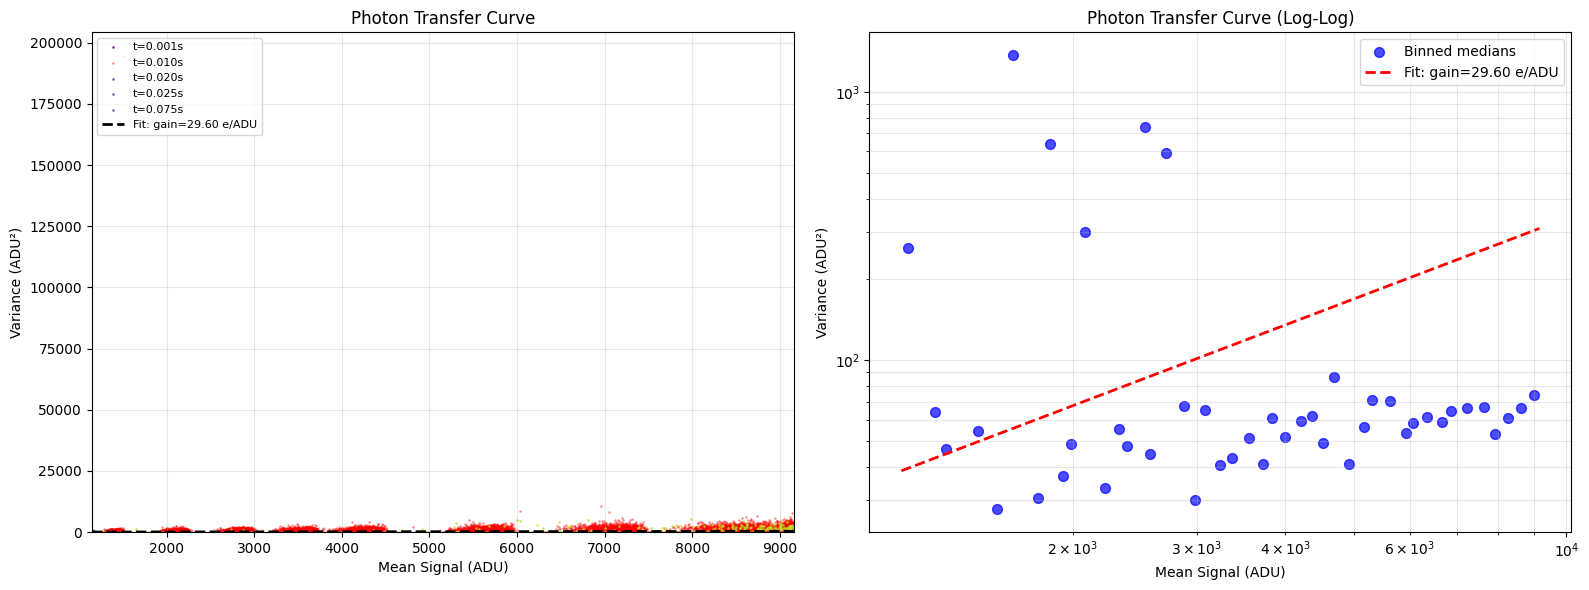

Median gain = 13.844 e/ADU
1/median gain = 0.072 ADU/e
Peak Slope = 0.002 ADU/e
Peak Gain = 662.687 e/ADU
FWHM = 0.086
Std from FWHM = 0.037


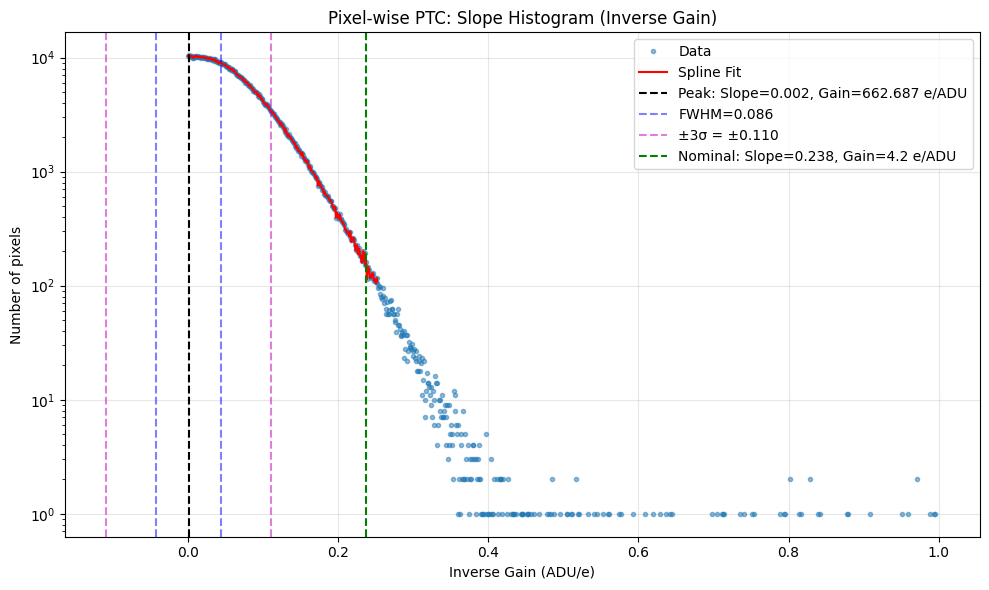

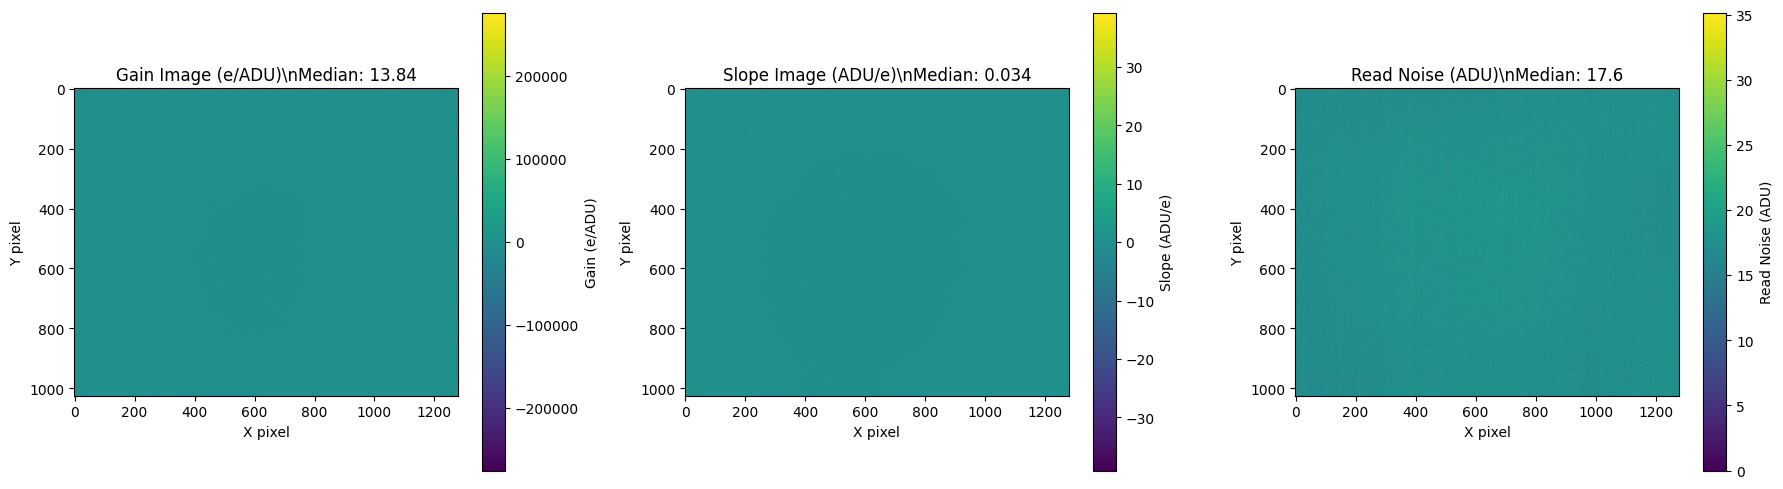

Saved PTC results to: /Users/nlourie/Library/CloudStorage/Box-Box/WINTER/WINTER – Public Data Workspace/pirt_camera/lab_testing/ramps/20250729_1050/processed/ptc_results.fits
Saved summary to: /Users/nlourie/Library/CloudStorage/Box-Box/WINTER/WINTER – Public Data Workspace/pirt_camera/lab_testing/ramps/20250729_1050/processed/ptc_summary.csv


In [12]:
# Create variance vs mean plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: All data points
colors = plt.cm.viridis(np.linspace(0, 1, len(df_filtered)))

for idx, (_, row) in enumerate(df_filtered.iterrows()):
    color = 'red' if row['outlier'] else colors[idx]
    alpha = 0.3 if row['outlier'] else 0.6
    
    mean_vals = row['mean_frame'].flatten()
    var_vals = row['var_frame'].flatten()
    
    # Subsample for plotting
    mask = (mean_vals > MEAN_MIN) & (mean_vals < MEAN_MAX)
    if mask.sum() > 1000:
        indices = np.where(mask)[0]
        indices = np.random.choice(indices, 1000, replace=False)
        mask = np.zeros_like(mask)
        mask[indices] = True
    
    ax1.scatter(mean_vals[mask], var_vals[mask], 
               c=[color], alpha=alpha, s=1,
               label=f"t={row['exposure_time']:.3f}s" if idx < 5 else "")

# Add fitted line
x_range = np.array([MEAN_MIN, MEAN_MAX])
median_slope = np.nanmedian(slope_image)
ax1.plot(x_range, median_slope * x_range, 'k--', linewidth=2, 
        label=f'Fit: gain={1/median_slope:.2f} e/ADU')

ax1.set_xlabel('Mean Signal (ADU)')
ax1.set_ylabel('Variance (ADU²)')
ax1.set_xlim(MEAN_MIN, MEAN_MAX)
ax1.set_ylim(bottom=0)
ax1.set_title('Photon Transfer Curve')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left', fontsize=8)

# Plot 2: Binned version
mean_bins = np.logspace(np.log10(MEAN_MIN), np.log10(MEAN_MAX), 50)
binned_means = []
binned_vars = []
binned_counts = []

for i in range(len(mean_bins)-1):
    bin_mask = np.zeros(0, dtype=bool)
    all_means = np.array([])
    all_vars = np.array([])
    
    for _, row in df_good.iterrows():
        mean_vals = row['mean_frame'].flatten()
        var_vals = row['var_frame'].flatten()
        mask = (mean_vals >= mean_bins[i]) & (mean_vals < mean_bins[i+1])
        all_means = np.concatenate([all_means, mean_vals[mask]])
        all_vars = np.concatenate([all_vars, var_vals[mask]])
    
    if len(all_means) > 0:
        binned_means.append(np.median(all_means))
        binned_vars.append(np.median(all_vars))
        binned_counts.append(len(all_means))

binned_means = np.array(binned_means)
binned_vars = np.array(binned_vars)

ax2.scatter(binned_means, binned_vars, c='blue', s=50, alpha=0.7, label='Binned medians')
ax2.plot(x_range, median_slope * x_range, 'r--', linewidth=2, 
        label=f'Fit: gain={1/median_slope:.2f} e/ADU')

ax2.set_xlabel('Mean Signal (ADU)')
ax2.set_ylabel('Variance (ADU²)')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_title('Photon Transfer Curve (Log-Log)')
ax2.grid(True, alpha=0.3, which='both')
ax2.legend()

plt.tight_layout()
plt.show()

# %% [markdown]
# ## Step 8: Analyze Gain Distribution

# %%
# Create detailed gain histogram
fig = analyzer.plot_gain_histogram(slope_image, gain_image, NOMINAL_GAIN)
plt.show()

# Display spatial variation
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Gain image
im1 = axes[0].imshow(gain_image, cmap='viridis', 
                     vmin=median_gain - 2*std_gain, 
                     vmax=median_gain + 2*std_gain)
axes[0].set_title(f'Gain Image (e/ADU)\\nMedian: {median_gain:.2f}')
axes[0].set_xlabel('X pixel')
axes[0].set_ylabel('Y pixel')
plt.colorbar(im1, ax=axes[0], label='Gain (e/ADU)')

# Slope image
median_slope = np.nanmedian(slope_image)
std_slope = np.nanstd(slope_image)
im2 = axes[1].imshow(slope_image, cmap='viridis',
                     vmin=median_slope - 2*std_slope,
                     vmax=median_slope + 2*std_slope)
axes[1].set_title(f'Slope Image (ADU/e)\\nMedian: {median_slope:.3f}')
axes[1].set_xlabel('X pixel')
axes[1].set_ylabel('Y pixel')
plt.colorbar(im2, ax=axes[1], label='Slope (ADU/e)')

# Intercept image (read noise squared)
read_noise = np.sqrt(np.abs(intercept_image))
median_rn = np.nanmedian(read_noise)
im3 = axes[2].imshow(read_noise, cmap='viridis',
                     vmin=0, vmax=2*median_rn)
axes[2].set_title(f'Read Noise (ADU)\\nMedian: {median_rn:.1f}')
axes[2].set_xlabel('X pixel')
axes[2].set_ylabel('Y pixel')
plt.colorbar(im3, ax=axes[2], label='Read Noise (ADU)')

plt.tight_layout()
plt.show()

# %% [markdown]
# ## Step 9: Save Results

# %%
# Save processed data
output_dir = analyzer.processed_dir

# Save gain image as FITS
from astropy.io import fits

# Create primary HDU with gain image
primary_hdu = fits.PrimaryHDU(gain_image)
primary_hdu.header['MEDGAIN'] = (median_gain, 'Median gain (e/ADU)')
primary_hdu.header['MEANGAIN'] = (mean_gain, 'Mean gain (e/ADU)')
primary_hdu.header['STDGAIN'] = (std_gain, 'Std dev of gain (e/ADU)')
primary_hdu.header['BUNIT'] = 'e/ADU'

# Create HDU list with additional images
hdul = fits.HDUList([
    primary_hdu,
    fits.ImageHDU(slope_image, name='SLOPE'),
    fits.ImageHDU(intercept_image, name='INTERCEPT'),
    fits.ImageHDU(read_noise, name='READNOISE')
])

output_fits = output_dir / 'ptc_results.fits'
hdul.writeto(output_fits, overwrite=True)
print(f"Saved PTC results to: {output_fits}")

# Save analysis summary as CSV
summary_data = {
    'exposure_time': df_filtered['exposure_time'].values,
    'num_frames': [row['num_frames'] for _, row in df_filtered.iterrows()],
    'mean_signal': [np.nanmean(row['mean_frame']) for _, row in df_filtered.iterrows()],
    'mean_variance': [np.nanmean(row['var_frame']) for _, row in df_filtered.iterrows()],
    'outlier': df_filtered['outlier'].values
}

summary_df = pd.DataFrame(summary_data)
summary_csv = output_dir / 'ptc_summary.csv'
summary_df.to_csv(summary_csv, index=False)
print(f"Saved summary to: {summary_csv}")
